<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 0 - Introducción a Redes Neuronales </H3>
<div align='center'>
###  Felipe González - 201273534-3 
### Ignacio Tampe - 201573514-k 
</div>
<hr style="height:2px;border:none"/>

## 1. Back-propagation (BP) from *Scratch*


In [6]:
import numpy as np
import random

In [18]:
class RedNeuronal:
    
    # num_entrada: dimension de los vectores de entrada, en iris: 4
    # tam_capas: lista de cantidad de neuronas por cada capa interna, en iris: [32, 16]
    # num_salida: dimension de los vectores de salida, en iris: 3
    # act_inter: función de activación de capas internas: "sigmoid" / "relu" / "arctan" / "softmax"
    # cost_func: función de costo: "crossentropy" / "mse" 
    def __init__(self, num_entrada, tam_capas, num_salida, act_inter, cost_func):
        self.num_entrada = num_entrada
        self.tam_capas = tam_capas
        self.num_salida = num_salida
        self.capas = []
        # iniciar todas las capas inicial - ocultas - final
        self.capas.append(CapaNeuronal(num_entrada, act_inter))
        for i in range(len(tam_capas)):
            self.capas.append(CapaNeuronal(tam_capas[i], act_inter, self.capas[i].tam_capa))
        self.capas.append(CapaNeuronal(num_salida, "softmax", self.capas[len(self.capas)-1].tam_capa))
        self.cant_capas = len(self.capas)
        if cost_func == "crossentropy":
            self.cost = self.crossentropy
            self.cost_derivative = self.crossentropy_derivative
        elif cost_func == "mse":
            self.cost = self.mse
            self.cost_derivative = self.mse_derivative
        print("Red Neuronal creada")
        print("\tCapas:", num_entrada, tam_capas, num_salida)
        print("\tActivación interna:", act_inter)
        print("\tFunción de costo:", cost_func)

    def crossentropy(self, prediccion, esperado, epsilon=1e-12): #El epsilon evita log(0)
        prediccion = np.clip(prediccion, epsilon, 1. - epsilon)
        N = prediccion.shape[0]
        ce = -np.sum(np.sum(esperado*np.log(prediccion+epsilon)))/N
        return ce
    
    def crossentropy_derivative(self, prediccion, esperado):
        return (esperado-1/prediccion+(1+esperado)*(1/(1-prediccion)))  
    
    def mse(self, prediccion, esperado):
        return np.dot(prediccion-esperado, prediccion-esperado)
    
    def mse_derivative(self, prediccion, esperado):
        return prediccion-esperado
    
    # train(entrada, salida, ciclos, tasa):
    # entrada: lista de datos de entrada
    # salida: lista de vectores de salida tipo onehot
    # ciclos: cantidad de epochs
    # tasa: tasa de aprendizaje 
    # verbose: Booleano que indica progreso por epoch o solo el final
    # momentum: agrega la posibilidad de entrenar con momentum, recibe el valor de éste.
    # retorna loss y accuracy
    def train(self, entrada, salida, ciclos, tasa, verbose = False, momentum = None):
        last = self.cant_capas-1 # indice capa de salida
        result = zip(entrada,salida)
        resultList = list(result)
        loss = []
        accuracy = []
        print("Comienza entrenamiento de red", end=" ")
        if momentum:
            print("con momentum", momentum)
        else:
            print()
        for ciclo in range(ciclos):
            # Comienza 1 epoch
            random.shuffle(resultList)
            errores = []
            acertados = 0
            primera_iter = True
            lista_delta_pesos = list(np.zeros(self.cant_capas))
            for input_v, output in resultList:
                #Poblar capa inicial
                self.capas[0].set_capa(input_v, input_v) 
                
                # Feed forward 
                for j in range(1, len(self.capas)):
                    self.capas[j].feed_forward(self.capas[j-1])
                
                # evaluar error final (delta función costo)
                prediccion = self.capas[last].get_activaciones()
                error_epoch = self.cost(self.capas[last].get_activaciones(), output)
                errores.append(error_epoch)
                
                if (np.argmax(prediccion) == np.argmax(output)):
                    acertados += 1
                
                #Backward pass capa final
                ce_derivate = self.cost_derivative(prediccion, np.transpose(output))
                delta = ce_derivate * self.capas[last].squash_derivative(self.capas[last].get_vector_z())
                
                self.capas[last].actualizar_bias(delta, tasa)
                
                delta_peso = np.outer(self.capas[last-1].get_activaciones(), delta)
                
                if momentum:
                    if primera_iter:
                        self.capas[last].actualizar_pesos(delta_peso, tasa)
                    else:
                        self.capas[last].actualizar_pesos_momentum(delta_peso, tasa, momentum, lista_delta_pesos[last])
                    lista_delta_pesos[last] = tasa*delta_peso
                else:
                    self.capas[last].actualizar_pesos(delta_peso, tasa)
                #Backward pass general
                for l in range(2, self.cant_capas):
                    z = self.capas[-l].get_vector_z()
                    act_prime = self.capas[-l].squash_derivative(z)
                    delta = np.dot(self.capas[-l+1].get_pesos(), delta.transpose()) * act_prime
                    delta_peso = np.outer(self.capas[-l-1].get_activaciones(),delta)
                    
                    self.capas[-l].actualizar_bias(delta, tasa)
                    if momentum:
                        if primera_iter:
                            self.capas[-l].actualizar_pesos(delta_peso, tasa)
                        else:
                            self.capas[-l].actualizar_pesos_momentum(delta_peso, tasa, momentum, lista_delta_pesos[-l])
                        #Actualizacion de lista de pesos
                        lista_delta_pesos[-l] = np.outer(self.capas[-l-1].get_activaciones(), delta)
                    else:
                        self.capas[-l].actualizar_pesos(delta_peso, tasa)
                        
                primera_iter = True
            loss.append(np.mean(errores))
            accuracy.append(acertados/len(resultList))
            primera_ter = False
            if verbose:
                print("\tError del epoch "+str(ciclo)+": loss", str(np.round(np.mean(errores),5)),"- acc", acertados/len(resultList))
        print("Resultado de training set de", ciclos,"epochs: loss", np.mean(errores),"- acc:", acertados/len(resultList))
        return loss, accuracy

    # test(entrada, salida):
    # entrada: lista de datos de entrada de test
    # salida: Lista de datos esperados de test, en formato onehot vector
    # retorna loss y accuracy
    def test(self, entrada, salida):
        # repetir para todas 
        last = self.cant_capas-1 # indice capa de salida
        result = zip(entrada,salida)
        resultList = list(result)
        errores = []
        acertados = 0
        for input_v, output in resultList:
            self.capas[0].set_capa(input_v, input_v) #Poblar capa inicial
            # Feed forward 
            for j in range(1, len(self.capas)):
                self.capas[j].feed_forward(self.capas[j-1])

            
            prediccion = self.capas[last].get_activaciones()
            
            if (np.argmax(prediccion) == np.argmax(output)):
                    acertados += 1
                    
            # evaluar error final (delta función costo)
            error_epoch = self.crossentropy(prediccion, output)
            errores.append(error_epoch)
        
        print("Error del test: loss", str(np.round(np.mean(errores),5)),"- acc", acertados/len(resultList))
        return np.mean(errores), acertados/len(resultList)
    
    def predict(self, entrada, categorias):
        last = self.cant_capas-1
        self.capas[0].set_capa(entrada, entrada)
        
        for j in range(1, len(self.capas)):
                self.capas[j].feed_forward(self.capas[j-1])
        
        prediccion = self.capas[last].get_activaciones()
        
        return categorias[np.argmax(prediccion)]

In [13]:
class CapaNeuronal:
    def __init__(self, tam_capa, tipo, tam_anterior = 0):
        self.tam_capa = tam_capa
        self.tam_anterior = tam_anterior
        self.bias = 1
        self.neuronas = [Neurona(tam_anterior) for i in range(tam_capa)] # lista de neuronas de la capa
        if tipo == "sigmoid":
            self.squash = self.sigmoid
            self.squash_derivative = self.sigmoid_derivative
        elif tipo == "softmax":
            self.squash = self.softmax
            self.squash_derivative = self.softmax_derivative
        elif tipo == "arctan":
            self.squash = self.arctan
            self.squash_derivative = self.arctan_derivative
        elif tipo == "relu":
            self.squash = self.relu
            self.squash_derivative = self.relu_derivative
       
    def sigmoid(self, x):
        return np.array([np.where(i > 0, 1. / (1. + np.exp(-i)), np.exp(i) / (np.exp(i) + np.exp(0))) for i in x])
    
    def sigmoid_derivative(self, x):
        return np.multiply(self.sigmoid(x),(1-self.sigmoid(x)))
    
    def arctan(self, x):
        return np.arctan(x)
    
    def arctan_derivative(self, x):
        return np.power(np.cos(x),2)
        
    def relu(self, x):
        x= np.array(x)
        return np.maximum(x, 0, x)
    
    def relu_derivative(self, x):
        x = np.array(x)
        return (x > 0).astype(int)
    
    def softmax(self, x):
        x = np.clip(x, -350, 350)
        return np.exp(x) / np.sum(np.exp(x), axis=0)
    
    def softmax_derivative(self, x):
        x = np.clip(x, -350, 350)
        res = []
        for i in x:
            res.append(np.exp(i)*(np.sum(np.exp(x), axis=0)-np.exp(i))/(np.sum(np.exp(x), axis=0)**2))
        #print(x)
        return np.array(res)
    
    def get_activaciones(self):
        return np.array([neurona.activacion for neurona in self.neuronas])
    
    def get_vector_z(self):
        return [neurona.z for neurona in self.neuronas]
    
    
    def feed_forward(self, capa_anterior):
        pre_squash = []
        activaciones = capa_anterior.get_activaciones()
        vector_z = capa_anterior.get_vector_z()
        for neurona in self.neuronas:
            pesos = neurona.pesos
            pre_squash.append(np.dot(pesos, activaciones) + neurona.bias)
        self.set_capa(self.squash(pre_squash), pre_squash)
   
    def get_pesos(self):
        return np.transpose(np.array([n.pesos for n in self.neuronas]))

    def actualizar_pesos(self, matriz, rate, momentum = 0, prev_delta_pesos = 0):
        pesos = np.transpose(np.array([n.pesos for n in self.neuronas]))
        pesos -= rate*matriz + momentum*prev_delta_pesos
        for i in range(len(self.neuronas)):
            self.neuronas[i].pesos = pesos[:,i]
    
    def actualizar_bias(self, vector_b, rate):
        biases = np.array([n.bias for n in self.neuronas])
        biases -= rate*vector_b #SE PUSO SUMA PORQUE BAJABA EL ERROR DEL EPOCH
        for i in range(len(self.neuronas)):
            self.neuronas[i].bias = biases[i]
    
    #Funcion para poblar datos de entrada a la red.
    def set_capa(self, activaciones, vector_z):
        for i in range(len(self.neuronas)):
            self.neuronas[i].set_activacion(activaciones[i], vector_z[i])
            
    def mostrar_capa(self):
        for neurona in self.neuronas:
            print(neurona, end="\t")
        print("\n-----------------------------")

        
class Neurona:
    def __init__(self, tam_capa_anterior):
        self.pesos = np.random.rand(tam_capa_anterior) # genera una lista de numeros aleatorios de tamaño "tam_capa_anterior"
        self.bias = np.random.rand()
        
    def set_activacion(self, valor_a, valor_z):
        self.activacion = valor_a
        self.z = valor_z
        
    def __str__(self):
        return "Activación: "+str(self.activacion)

### ¡Es hora de probar!

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import keras
x, y = load_iris(return_X_y=True)
scaler = StandardScaler().fit(x)
x = scaler.transform(x) 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=50)
y_onehot_train = keras.utils.to_categorical(y_train)
y_onehot_test = keras.utils.to_categorical(y_test)
tags = ['setosa', 'versicolor', 'verginica']

In [27]:
# Instanciar red neuronal
nn_sm = RedNeuronal(4, [32, 16], 3, "sigmoid", "mse")
nn_sm_m = RedNeuronal(4, [32, 16], 3, "sigmoid", "mse")

Red Neuronal creada
	Capas: 4 [32, 16] 3
	Activación interna: sigmoid
	Función de costo: mse
Red Neuronal creada
	Capas: 4 [32, 16] 3
	Activación interna: sigmoid
	Función de costo: mse


In [35]:
#Entrenar la red
loss_sm, accuracy_sm = nn_sm.train(x_train, y_onehot_train, 100, 0.1, verbose = False)
loss_sm_m, accuracy_sm_m = nn_sm_m.train(x_train, y_onehot_train, 100, 0.1, verbose = False, momentum = 0.9)
#Testear
print("\nTESTING")
nn_sm.test(x_test, y_onehot_test)
nn_sm_m.test(x_test, y_onehot_test)

Comienza entrenamiento de red 
Resultado de training set de 100 epochs: loss 0.0357282355414 - acc: 0.9833333333333333
Comienza entrenamiento de red con momentum 0.9
Resultado de training set de 100 epochs: loss 0.0980155177891 - acc: 0.975

TESTING
Error del test: loss 0.0552 - acc 0.9
Error del test: loss 0.08712 - acc 0.9


(0.087115283116543152, 0.9)

In [36]:
x_predict = x_test[5]

print("Probando para", tags[np.argmax(y_onehot_test[5])])
print("Predicción de NN:",nn.predict(x_predict, tags))

Probando para verginica
Predicción de NN: verginica


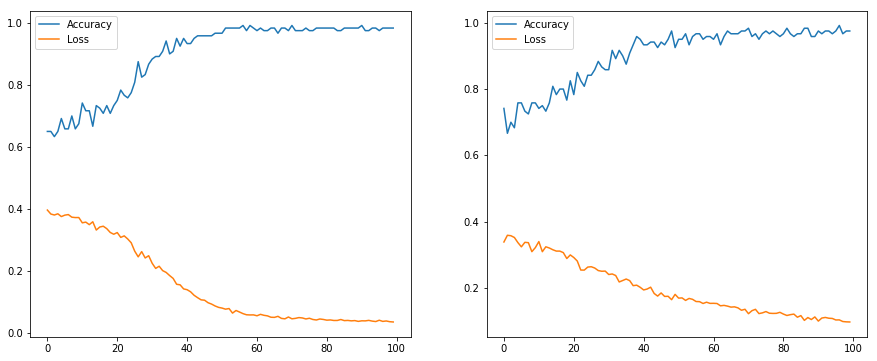

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(1, figsize=(15,6))
plt.subplot(121)
plt.plot(range(len(accuracy_sm)), accuracy_sm, label="Accuracy")
plt.plot(range(len(loss_sm)), loss_sm, label="Loss")
plt.legend()
plt.subplot(122)
plt.plot(range(len(accuracy_sm_m)), accuracy_sm_m, label="Accuracy")
plt.plot(range(len(loss_sm_m)), loss_sm_m, label="Loss")
plt.legend()
plt.show()

## 1. Referencias


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

### Pregunta 2

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(32, input_dim=x_train.shape[1], activation="sigmoid"))
model.add(Dense(16, activation="sigmoid"))
model.add(Dense(3, activation="softmax"))
model.compile(optimizer=SGD(lr=0.1),loss="mse", metrics=["accuracy"])

In [ ]:
model.fit(x_train, y_onehot_train, epochs=100, batch_size=1, verbose=1)